<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Standard-Packages" data-toc-modified-id="Import-Standard-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Standard Packages</a></span></li><li><span><a href="#Import-Symawofo-Packages" data-toc-modified-id="Import-Symawofo-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Symawofo Packages</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Add-Additional-Features" data-toc-modified-id="Add-Additional-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add Additional Features</a></span></li><li><span><a href="#Construct-Base-Model" data-toc-modified-id="Construct-Base-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Construct Base Model</a></span></li><li><span><a href="#Define-all-the-SubStrats" data-toc-modified-id="Define-all-the-SubStrats-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define all the SubStrats</a></span></li><li><span><a href="#Train/Test-the-SubStrats" data-toc-modified-id="Train/Test-the-SubStrats-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train/Test the SubStrats</a></span></li></ul></div>

# Import Standard Packages

In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from pathlib import Path
from copy import deepcopy
from datetime import datetime
import dill
from tqdm.auto import tqdm
import json

# internal
import sys
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")
sys.path.append(r"C:\SyMAWoFlo\Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\ami")

# Import Symawofo Packages

In [2]:
from symawofo import make_pipeline, WindowFrame, DataSplitter, FeatureFrame, FeatureSeries
from symawofo.transformers import Lag, Difference, StandardScaler, TransformedTargetRegressor, Clipper, Pipeline
from symawofo.model_selection.sk import GridSearchCV
from symawofo.models.base import model as model_dec, RegressorMixin2d, BaseModel
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.pnl.base import AssetType
from symawofo.metrics import make_scorer
from symawofo.pnl import PNL
from symawofo.shared.utils import to_pickle, read_pickle

In [3]:
from symawofo import get_client
client = get_client('local')

/home/osindi/env/symawofo2/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33867 instead
  warnings.warn(


# Load Data

In [4]:
df_master_daily = pd.read_csv('Transformed_Data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
df_master_daily = df_master_daily.join(pd.read_csv('DXY.csv', index_col=0))
df_master_daily['US_Equity_Real_Vol1m'] = np.exp(df_master_daily['US_Equity_Fut']).pct_change().rolling(21).std()*np.sqrt(252)
df_master_weekly = df_master_daily[df_master_daily.index.weekday==4].copy() # Convert to weekly! Fridays (i.e. .resample('W-FRI').last())
df_master_weekly.tail()

UK_Equity_Vol  SEK_Equity_Vol  JPN_Nikkei_PE  US_Credit_IG_OAS  \
2020-06-26          26.89           27.14        27.4870          0.693702   
2020-07-03          23.02           24.31        27.2690          0.658068   
2020-07-10          23.60           23.92        27.2499          0.641216   
2020-07-17          21.56           22.09        27.7457          0.633169   
2020-07-24          21.74           22.02        27.8132          0.622158   

            US_Credit_HY_OAS  JPN_Credit_IG_OAS  EMU_Credit_IG_OAS  \
2020-06-26          6.153414           0.624857           0.754222   
2020-07-03          6.003799           0.623595           0.728486   
2020-07-10          5.967674           0.604368           0.726914   
2020-07-17          5.563074           0.608347           0.689635   
2020-07-24          5.042923           0.619334           0.640341   

            EMU_Credit_HY_OAS  UK_Credit_IG_OAS  UK_Credit_HY_OAS  ...  \
2020-06-26           5.316320          1.761242          6.900926  ...   
2020-07-03           5.225561          1.719609          6.835161  ...   
2020-07-10           5.249594          1.685940          6.926201  ...   
2020-07-17           5.072157          1.646381          6.825860  ...   
2020-07-24           4.816503          1.588846          6.715479  ...   

            JPY_CBEI_G_raw  JPY_CBBI_G_raw  JPY_CBEI_I_raw  JPY_CBBI_I_raw  \
2020-06-26       -0.528821       45.721187       -1.588272       43.224932   
2020-07-03       -0.528821       45.721187       -1.588272       43.224932   
2020-07-10       -0.528821       45.721187       -1.588272       43.224932   
2020-07-17       -0.528821       45.721187       -1.588272       43.224932   
2020-07-24       -0.528821       45.721187       -1.588272       43.224932   

            USD_CBEI_G_raw  USD_CBBI_G_raw  USD_CBEI_I_raw  USD_CBBI_I_raw  \
2020-06-26        1.298895       22.537034        0.878475       -7.529489   
2020-07-03        1.298895       22.537034        0.878475       -7.529489   
2020-07-10        1.298895       22.537034        0.878475       -7.529489   
2020-07-17        1.298895       22.537034        0.878475       -7.529489   
2020-07-24        1.298895       22.537034        0.878475       -7.529489   

               DXY  US_Equity_Real_Vol1m  
2020-06-26  97.433              0.278372  
2020-07-03  97.172              0.282935  
2020-07-10  96.652              0.190586  
2020-07-17  95.942              0.189110  
2020-07-24  94.435              0.163983  

[5 rows x 2862 columns]

# Add Additional Features

In [5]:
def zscore(x, w=10):
    return (x-x.rolling(w).mean())/x.rolling(w).std()


df_master_weekly['US_Equity_Fut_ChgP'] = np.exp(df_master_weekly['US_Equity_Fut']).pct_change()
df_master_weekly['US_Equity_Vol_Chg'] = df_master_weekly['US_Equity_Vol'].diff()
df_master_weekly['Mom_Change_SPX'] = df_master_weekly['US_Equity'].pct_change(4)*52/4 - df_master_weekly['US_Equity'].pct_change(52)
df_master_weekly['DXY_ChgP'] = df_master_weekly['DXY'].pct_change()
df_master_weekly['SPGSIN_Chg13'] = df_master_weekly['GLOB_Ind_metals'].diff(13)
df_master_weekly['eq_per_flows_USA'] = df_master_weekly['eq_per_flows_USA']
df_master_weekly['US_Equity_Real_Vol1m_Chg'] = df_master_weekly['US_Equity_Real_Vol1m'].diff()
df_master_weekly['US_Lois3m_Chg'] = df_master_weekly['US_Lois3m'].diff()
df_master_weekly['US_2y_v_OIS_ZSc52'] = zscore(df_master_weekly['US_2y_v_OIS'], 52)
df_master_weekly['US_Bond_30y_ZSc52'] = zscore(df_master_weekly['US_Bond_30y'], 52)
df_master_weekly['US_10y_2y_ZSc52'] = zscore((df_master_weekly['US_Bond_10y']-df_master_weekly['US_Bond_2y']), 52)
df_master_weekly['GLOB_EM_HCSp_Chg'] = df_master_weekly['GLOB_EM_HCSp'].diff()

df_master_weekly['US_HYIG_Spread'] = df_master_weekly['US_Credit_HY_OAS']-df_master_weekly['US_Credit_IG_OAS']

df_master_weekly['US_Credit_HY_OAS_Chg'] = df_master_weekly['US_Credit_HY_OAS'].diff()
df_master_weekly['US_Credit_HY_IG_Chg'] = df_master_weekly['US_Credit_IG_OAS'].diff()
df_master_weekly['US_HYIG_Spread_Chg'] = df_master_weekly['US_HYIG_Spread'].diff()
df_master_weekly['US_Credit_HY_OAS_ZSc52'] = zscore(df_master_weekly['US_Credit_HY_OAS'],52)
df_master_weekly['US_Credit_HY_IG_ZSc52'] = zscore(df_master_weekly['US_Credit_IG_OAS'],52)
df_master_weekly['US_HYIG_Spread_ZSc52'] = zscore(df_master_weekly['US_HYIG_Spread'],52)

# Construct Base Model

In [6]:
from sklearn.model_selection import ParameterGrid

@model_dec(RegressorMixin2d)
class SubStrat(sk.base.BaseEstimator):
    def __init__(self, param_grid, scoring):
        self.param_grid = ParameterGrid(param_grid)
        
        self.func = None
        self.thresh = None
        
        self.best_params_ = {'func': None, 'thresh': None, 'score': -np.inf}
        
        self.scorer = scoring
        
    def fit(self, X, y):
        
        for params in self.param_grid:
            self.func = params['func']
            self.thresh = params['thresh']
            score = self.scorer(y, self.predict(X).data)
            if score > self.best_params_['score']:
                self.best_params_['func'] = self.func
                self.best_params_['thresh'] = self.thresh
                self.best_params_['score'] = score
                
        self.func = self.best_params_['func']
        self.thresh = self.best_params_['thresh']

        return self
    
    def predict(self, X):
        return self.func(X, self.thresh)

def make_model(param_grid, scoring_func):

    my_model = SubStrat(lags=0, param_grid=param_grid, scoring=scoring_func)
    
    return my_model
    
# This is a signal class compatible with Symawofo for 'Buy&Hold' strategy
class LongOnly:
    def __init__(self, target, index):
        self.target = target
        self.index = index

    def get_signals(self):
        return pd.Series(np.ones(len(target)), index=target.data.index, dtype='float').reindex(self.index)
    
    
def long_only_relative_mean_score(y, y_pred):
    return np.mean(y_pred*y) - np.mean((1-y_pred)*y)

def mean_score(y, y_pred):
    return np.mean(y_pred*y)

def sharpe_score(y, y_pred):
    return np.mean(y_pred*y)/np.std(y_pred*y)

def active_mean_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx])

def active_sharpe_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx])/np.std(y_pred[idx]*y[idx])

def ctail_score(y, y_pred):
    strat = y_pred*y
    top_percentile = np.percentile(strat, 90)
    idx = strat>top_percentile
    return np.mean(strat[idx])

def short(fn):
    def wrapper(x, y):
        return -fn(x, y)
    return wrapper


def mixed(x, threshold): #param_grid_func
    return np.less(x, threshold).astype(float)-np.greater(x, threshold).astype(float)

In [7]:
def active_mean_reg_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx]) * np.log(np.sum(idx))

y = np.array([0.1, 0.1, -0.05, 0.2, -0.1])
y_pred_case1 = np.array([1, 0, 0, 0, 0])

active_mean_score(y, y_pred_case1)

0.1

In [8]:
df_master_weekly['US_Credit_HY_OAS_Chg'].quantile(0.75)

0.1091245000000014

# Define all the SubStrats

In [23]:
asset = 'US_Equity_Fut'


substrat_meta_list = [
 {'feature_name': 'US_Equity_Fut_ChgP',
  'param_grid': {'func': [np.less], 'thresh': [-0.005, -0.0025, 0.0, 0.0025, 0.005]},
    'feature_preprocessing': None,
  'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'US_Equity_Real_Vol1m_Chg',
  'param_grid': {'func': [mixed], 'thresh': np.linspace(-2, 2, num=20)},
 'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'US_Lois3m_Chg',
  'param_grid': {'func': [mixed], 'thresh': np.linspace(-2, 2, num=20)},
 'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'US_Equity_Vol_Chg',
   'param_grid': {'func': [np.greater], 'thresh': np.linspace(-2, 2, num=20)},
 'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'DXY_ChgP',
  'param_grid': {'func': [np.less], 'thresh': np.linspace(-0.01, 0, num=20)},
 'feature_preprocessing': None,
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'SPGSIN_Chg13',
  'param_grid': {'func': [np.greater], 'thresh': np.linspace(0, 0.06, num=20)},
 'feature_preprocessing': None,
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'eq_per_flows_USA',
  'param_grid': {'func': [np.less, np.greater], 'thresh': np.linspace(-2, 2, num=20)},
 'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
 'scoring_func': active_mean_reg_score},
                      
 {'feature_name': 'US_2y_v_OIS_ZSc52',
  'param_grid': {'func': [np.less], 'thresh': np.linspace(-2, 0, num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
                      
 {'feature_name': 'US_Bond_30y_ZSc52',
  'param_grid': {'func': [np.less], 'thresh': np.linspace(-2, 0, num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
                      
 {'feature_name': 'US_10y_2y_ZSc52',
  'param_grid': {'func': [np.less], 'thresh': np.linspace(-2, 0, num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
                      
 {'feature_name': 'GLOB_EM_HCSp_Chg',
  'param_grid': {'func': [np.greater], 'thresh': np.linspace(0, 6, num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score}
]

# substrat_meta_list = [
    
# {'feature_name': 'US_Credit_HY_OAS_Chg',
#   'param_grid': {'func': [np.greater], 'thresh': np.linspace(0, df_master_weekly['US_Credit_HY_OAS_Chg'].quantile(0.75), num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': active_mean_reg_score},
    
# {'feature_name': 'US_Credit_HY_IG_Chg',
#   'param_grid': {'func': [np.greater], 'thresh': np.linspace(0, df_master_weekly['US_Credit_HY_IG_Chg'].quantile(0.75), num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': active_mean_reg_score},
    
# {'feature_name': 'US_HYIG_Spread_Chg',
#   'param_grid': {'func': [np.greater], 'thresh': np.linspace(0, df_master_weekly['US_HYIG_Spread_Chg'].quantile(0.75), num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': active_mean_reg_score},
    
# {'feature_name': 'US_Credit_HY_OAS_ZSc52',
#   'param_grid': {'func': [np.less], 'thresh': np.linspace(df_master_weekly['US_Credit_HY_OAS_Chg'].quantile(0.25), 0, num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': mean_score},
    
# {'feature_name': 'US_Credit_HY_IG_ZSc52',
#   'param_grid': {'func': [np.less], 'thresh': np.linspace(df_master_weekly['US_Credit_HY_IG_ZSc52'].quantile(0.25), 0, num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': mean_score},
    
# {'feature_name': 'US_HYIG_Spread_ZSc52',
#   'param_grid': {'func': [np.less], 'thresh': np.linspace(df_master_weekly['US_HYIG_Spread_ZSc52'].quantile(0.25), 0, num=20)},
#  'feature_preprocessing': None,
#  'scoring_func': mean_score},
    
# ]

df_master_weekly['US_Credit_HY_OAS_Chg'] = df_master_weekly['US_Credit_HY_OAS'].diff()
df_master_weekly['US_Credit_HY_IG_Chg'] = df_master_weekly['US_Credit_IG_OAS'].diff()
df_master_weekly['US_HYIG_Spread_Chg'] = df_master_weekly['US_HYIG_Spread'].diff()

df_master_weekly['US_Credit_HY_OAS_ZSc52'] = zscore(df_master_weekly['US_Credit_HY_OAS'],52)
df_master_weekly['US_Credit_HY_IG_ZSc52'] = zscore(df_master_weekly['US_Credit_IG_OAS'],52)
df_master_weekly['US_HYIG_Spread_ZSc52'] = zscore(df_master_weekly['US_HYIG_Spread'],52)

common_meta_dict = {
    'splitter': DataSplitter(test_size=13,
                             initial_training_size=104,
                             expanding=True,
                             last_training_window=True),
    'feature_preprocessing': None,
#     'feature_preprocessing': make_pipeline(StandardScaler()),
    'target_preprocessing': make_pipeline(Difference(), Lag(-1)),
    'scoring_func': lambda y, y_pred: np.mean(y_pred*y) - np.mean((1-y_pred)*y),
    'target_name': asset
}

# Add common meta data to each entry in substrat_meta_list
for k, v in common_meta_dict.items():
    for i in range(len(substrat_meta_list)):
        if k not in substrat_meta_list[i]:  # Only override if it does not already exist
            substrat_meta_list[i][k] = deepcopy(v)

In [24]:
# df_master_weekly[['US_Equity_Fut_ChgP', 'DXY_ChgP']].plot(kind='scatter', x='US_Equity_Fut_ChgP', y='DXY_ChgP')

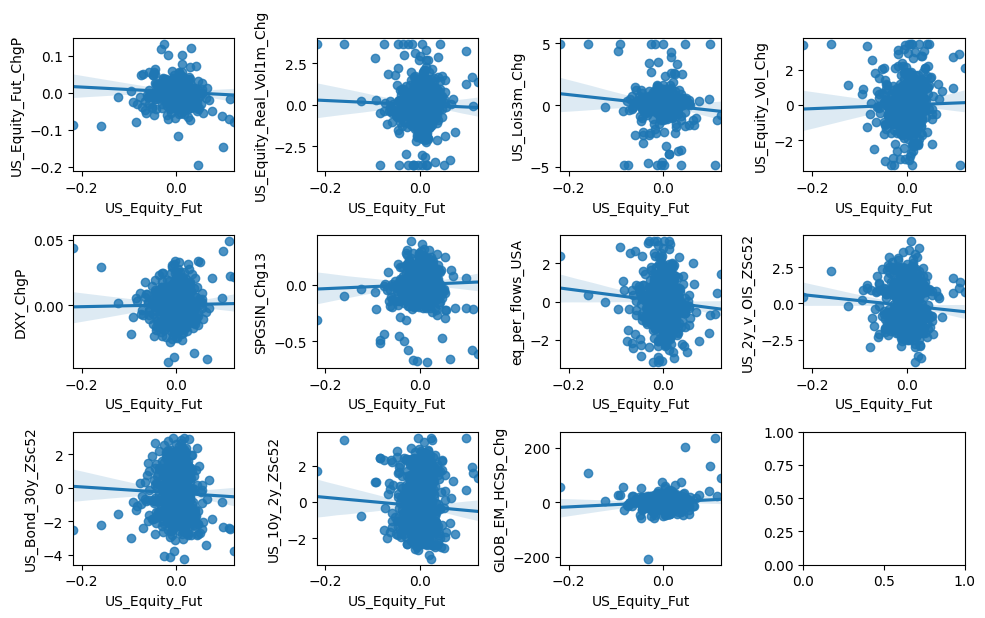

In [25]:
start_date = "2005"

fig, ax = plt.subplots(3, int(np.ceil(len(substrat_meta_list)/3)),
                       figsize=(10, 6), dpi=100)
ax = ax.flatten()
for i, meta in enumerate(tqdm(substrat_meta_list)):
    
    feature_name = meta['feature_name']
    target_name = meta['target_name']
    
    feature_preprocessing = meta['feature_preprocessing']
    target_preprocessing = meta['target_preprocessing']
    
    features = FeatureFrame(df_master_weekly[[feature_name]].loc[start_date:].copy().dropna())
    if feature_preprocessing is not None: 
        features = feature_preprocessing.fit_transform(features)
    
    target = FeatureFrame(df_master_weekly[[target_name]].loc[start_date:].copy().dropna()).squeeze()
    target = target_preprocessing.fit_transform(target)
    
    sns.regplot(x=target.data.values, y=features.data.values, ax=ax[i])
    ax[i].set(xlabel=target_name, ylabel=feature_name)
    
plt.tight_layout()
plt.show()

In [26]:
# for s in substrat_meta_list:
#     s['scoring_func'] = active_mean_reg_score

In [27]:

# spx_change_dict = {'feature_name': 'US_Equity_Fut_ChgP',
#                    'splitter': DataSplitter(test_size=25,
#                              initial_training_size=500,
#                              expanding=True,
#                              last_training_window=True),
#                    'target_preprocessing': make_pipeline(Difference(), Lag(-1)),
#                    'target_name': asset}



# scoring_list = [long_only_relative_mean_score, ctail_score, active_sharpe_score, active_mean_score, sharpe_score, mean_score]
# try1 = {'param_grid': {'func': [np.less, np.greater], 'thresh': np.linspace(-2, 2, num=20)},
#         'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler())}

# try2 = {'param_grid': {'func': [np.less, np.greater], 'thresh': np.linspace(-0.05, 0.05, num=20)},
#         'feature_preprocessing': None}


# spx_change_dict_list = []
# for scoring in scoring_list:
#     for tr in [try1, try2]:
#         temp_dict = deepcopy(spx_change_dict)
#         temp_dict['scoring_func'] = scoring
#         temp_dict.update(tr)
#         spx_change_dict_list.append(temp_dict)
                    

In [28]:
# # Original Config


# hyp = [('US_Equity_Fut_ChgP', '0', 'smaller', '1'),
#  ('US_Equity_Real_Vol1m_Chg', '0.1', 'mixed', '-3'),
#  ('US_Lois3m_Chg', '5', 'mixed', '-3'),
#  ('US_Equity_Vol_Chg', '0', 'larger', '1'),
#  ('Mom_Change_SPX', '0', 'larger', '1'),
#  ('DXY_ChgP', '0', 'smaller', '1'),
#  ('SPGSIN_Chg13', '0', 'larger', '1'),
#  ('eq_per_flows_USA', '0', 'smaller', '1'),
#  ('US_2y_v_OIS_ZSc52', '0', 'smaller', '1'),
#  ('US_Bond_30y_ZSc52', '0', 'smaller', '1'),
#  ('US_10y_2y_ZSc52', '0', 'smaller', '1'),
#  ('GLOB_EM_HCSp_Chg', '0', 'larger', '1')]



# def func_generator(cond):
#     if cond=='smaller':
#         return np.less
#     elif cond=='larger':
#         return np.greater
#     else:
#         return mixed
                

# meta_list = []
# for i in hyp:
#     meta_list.append(
#     {'feature_name': i[0],
#      'target_name': asset,
#      'param_grid': {
#          'func': [func_generator(i[2])],
#          'thresh': [float(i[1])]
#          }
#     }
#     )
    
# # for i in meta_list:
# #     i.update(common_meta_dict)

# Train/Test the SubStrats

{'feature_name': 'US_Equity_Fut_ChgP', 'param_grid': {'func': [<ufunc 'less'>], 'thresh': [-0.005, -0.0025, 0.0, 0.0025, 0.005]}, 'feature_preprocessing': None, 'scoring_func': <function active_mean_reg_score at 0x7f73ecc86790>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f73ecc897f0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', step=-1))]), 'target_name': 'US_Equity_Fut'}
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status


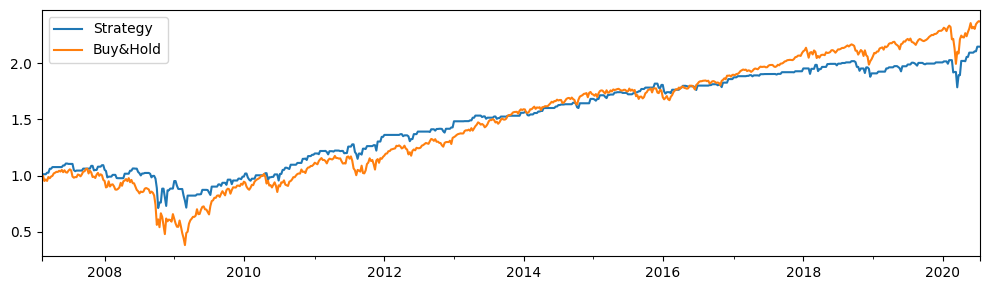



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0013944171997960946
Average Return Given A Signal: 0.0033706429553691806
Volatility: 0.022194822756208054
Volatility Given A Signal: 0.03444545239511444
Sharpe Ratio: 0.4530464395664042
Sharpe Ratio Given A Signal: 0.7056389254210392


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.4136947218259629 % of the time
Flat: 0.5863052781740371 % of the time
Short: 0.0 % of the time




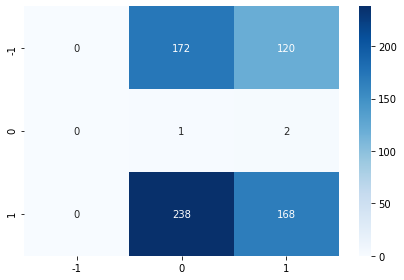

{'feature_name': 'US_Equity_Real_Vol1m_Chg', 'param_grid': {'func': [<function mixed at 0x7f73ecc91700>], 'thresh': array([-2.        , -1.78947368, -1.57894737, -1.36842105, -1.15789474,
       -0.94736842, -0.73684211, -0.52631579, -0.31578947, -0.10526316,
        0.10526316,  0.31578947,  0.52631579,  0.73684211,  0.94736842,
        1.15789474,  1.36842105,  1.57894737,  1.78947368,  2.        ])}, 'feature_preprocessing': Pipeline(steps=[('standardscaler-1',
                 StandardScaler(_name='StandardScaler', _new=True, _sep='_',
                                _store_parents_data=False,
                                _suffix='StandardScaler',
                                _uid='SgCAiyYv6wXPsM6BHM98PG')),
                ('clipper',
                 Clipper(_name='Clipper', _new=True, _sep='_',
                         _store_parents_data=False, _suffix='Clipper',
                         _uid='nJEuJGrcckCce4SPr9qh2z')),
                ('standardscaler-2',
               

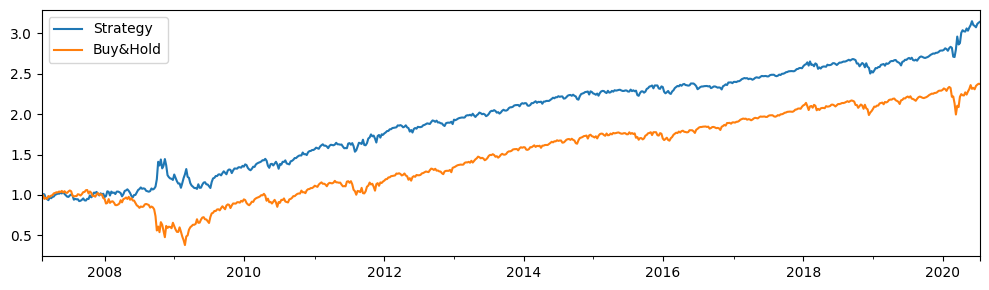



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0027047025085805273
Average Return Given A Signal: 0.002716327304462679
Volatility: 0.026443762487479424
Volatility Given A Signal: 0.026500013848406907
Sharpe Ratio: 0.7375609718307305
Sharpe Ratio Given A Signal: 0.739158661064009


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.8630527817403709 % of the time
Flat: 0.0 % of the time
Short: 0.1369472182596291 % of the time




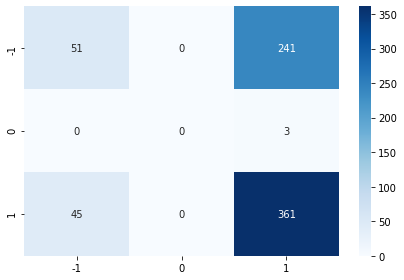

{'feature_name': 'US_Lois3m_Chg', 'param_grid': {'func': [<function mixed at 0x7f73ecc91700>], 'thresh': array([-2.        , -1.78947368, -1.57894737, -1.36842105, -1.15789474,
       -0.94736842, -0.73684211, -0.52631579, -0.31578947, -0.10526316,
        0.10526316,  0.31578947,  0.52631579,  0.73684211,  0.94736842,
        1.15789474,  1.36842105,  1.57894737,  1.78947368,  2.        ])}, 'feature_preprocessing': Pipeline(steps=[('standardscaler-1',
                 StandardScaler(_name='StandardScaler', _new=True, _sep='_',
                                _store_parents_data=False,
                                _suffix='StandardScaler',
                                _uid='2DRRLvVU3ggbHCdk33AsCa')),
                ('clipper',
                 Clipper(_name='Clipper', _new=True, _sep='_',
                         _store_parents_data=False, _suffix='Clipper',
                         _uid='LuB4rcgqtVGyTfpo4eW7L9')),
                ('standardscaler-2',
                 StandardS

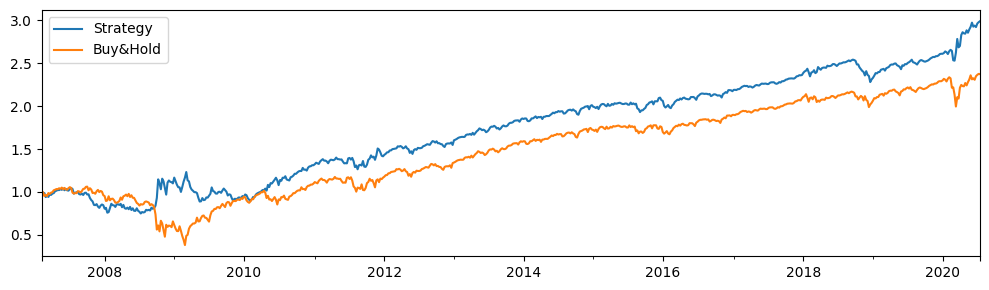



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0024852630262912744
Average Return Given A Signal: 0.0024959446725360797
Volatility: 0.026465318528604745
Volatility Given A Signal: 0.02652170952704965
Sharpe Ratio: 0.6771687455507387
Sharpe Ratio Given A Signal: 0.6786332146780821


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.8630527817403709 % of the time
Flat: 0.0 % of the time
Short: 0.1369472182596291 % of the time




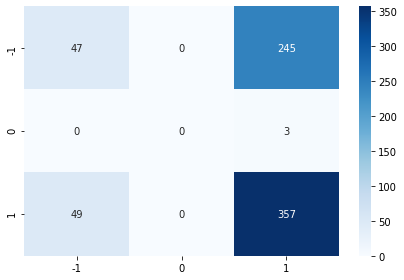

{'feature_name': 'US_Equity_Vol_Chg', 'param_grid': {'func': [<ufunc 'greater'>], 'thresh': array([-2.        , -1.78947368, -1.57894737, -1.36842105, -1.15789474,
       -0.94736842, -0.73684211, -0.52631579, -0.31578947, -0.10526316,
        0.10526316,  0.31578947,  0.52631579,  0.73684211,  0.94736842,
        1.15789474,  1.36842105,  1.57894737,  1.78947368,  2.        ])}, 'feature_preprocessing': Pipeline(steps=[('standardscaler-1',
                 StandardScaler(_name='StandardScaler', _new=True, _sep='_',
                                _store_parents_data=False,
                                _suffix='StandardScaler',
                                _uid='2vqcqL7wPWpa4m9jLe4byV')),
                ('clipper',
                 Clipper(_name='Clipper', _new=True, _sep='_',
                         _store_parents_data=False, _suffix='Clipper',
                         _uid='9ytMNABFedCvwxGcjGzWaS')),
                ('standardscaler-2',
                 StandardScaler(_name='

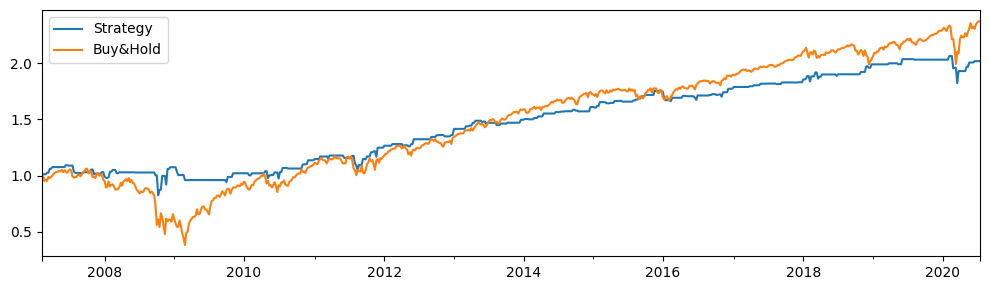



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0012871075788896263
Average Return Given A Signal: 0.004957485784624329
Volatility: 0.018416057102257535
Volatility Given A Signal: 0.035963007938692906
Sharpe Ratio: 0.5039876176487283
Sharpe Ratio Given A Signal: 0.9940475070560242


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.25962910128388017 % of the time
Flat: 0.7403708987161198 % of the time
Short: 0.0 % of the time




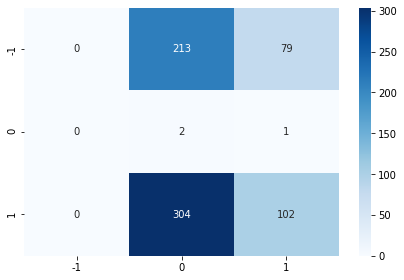

{'feature_name': 'DXY_ChgP', 'param_grid': {'func': [<ufunc 'less'>], 'thresh': array([-0.01      , -0.00947368, -0.00894737, -0.00842105, -0.00789474,
       -0.00736842, -0.00684211, -0.00631579, -0.00578947, -0.00526316,
       -0.00473684, -0.00421053, -0.00368421, -0.00315789, -0.00263158,
       -0.00210526, -0.00157895, -0.00105263, -0.00052632,  0.        ])}, 'feature_preprocessing': None, 'scoring_func': <function active_mean_reg_score at 0x7f73ecc86790>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac850>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC',

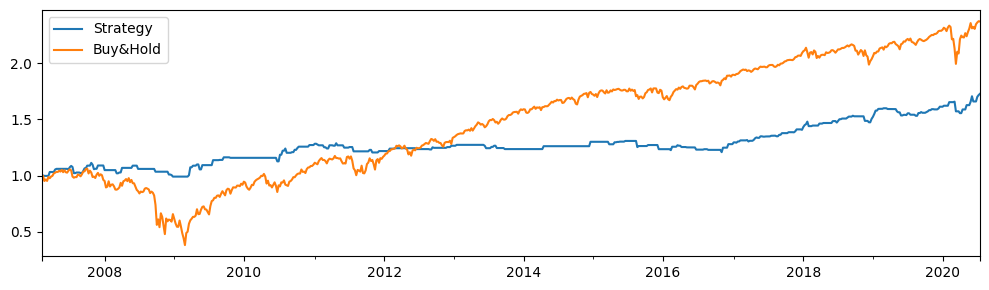



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0009754518621994172
Average Return Given A Signal: 0.0034887334459275075
Volatility: 0.011368817016265869
Volatility Given A Signal: 0.02133450786252879
Sharpe Ratio: 0.6187172686260751
Sharpe Ratio Given A Signal: 1.1791982647802994


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.2796005706134094 % of the time
Flat: 0.7203994293865906 % of the time
Short: 0.0 % of the time




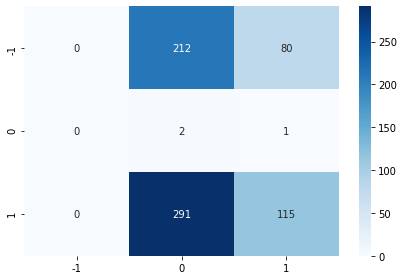

{'feature_name': 'SPGSIN_Chg13', 'param_grid': {'func': [<ufunc 'greater'>], 'thresh': array([0.        , 0.00315789, 0.00631579, 0.00947368, 0.01263158,
       0.01578947, 0.01894737, 0.02210526, 0.02526316, 0.02842105,
       0.03157895, 0.03473684, 0.03789474, 0.04105263, 0.04421053,
       0.04736842, 0.05052632, 0.05368421, 0.05684211, 0.06      ])}, 'feature_preprocessing': None, 'scoring_func': <function active_mean_reg_score at 0x7f73ecc86790>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac5b0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', step=-1))]),

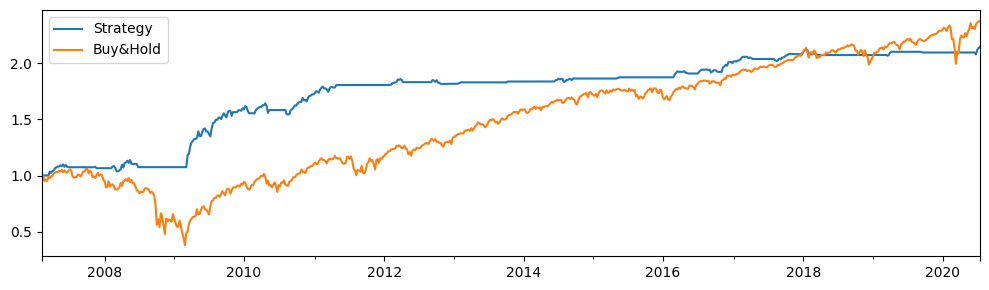



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0015724208491049848
Average Return Given A Signal: 0.004650915676044702
Volatility: 0.011432080699729182
Volatility Given A Signal: 0.019320162152716733
Sharpe Ratio: 0.9918481415532611
Sharpe Ratio Given A Signal: 1.7359186548525343


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.340941512125535 % of the time
Flat: 0.6590584878744651 % of the time
Short: 0.0 % of the time




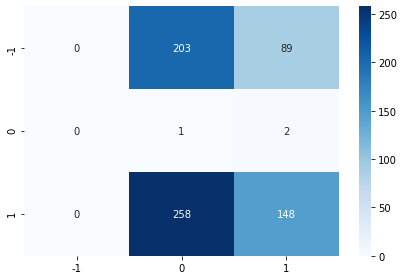

{'feature_name': 'eq_per_flows_USA', 'param_grid': {'func': [<ufunc 'less'>, <ufunc 'greater'>], 'thresh': array([-2.        , -1.78947368, -1.57894737, -1.36842105, -1.15789474,
       -0.94736842, -0.73684211, -0.52631579, -0.31578947, -0.10526316,
        0.10526316,  0.31578947,  0.52631579,  0.73684211,  0.94736842,
        1.15789474,  1.36842105,  1.57894737,  1.78947368,  2.        ])}, 'feature_preprocessing': Pipeline(steps=[('standardscaler-1',
                 StandardScaler(_name='StandardScaler', _new=True, _sep='_',
                                _store_parents_data=False,
                                _suffix='StandardScaler',
                                _uid='4E2cR9JJCWjsALZxtkP8e4')),
                ('clipper',
                 Clipper(_name='Clipper', _new=True, _sep='_',
                         _store_parents_data=False, _suffix='Clipper',
                         _uid='LpG6ddCKjKa8v7FNEpHK4f')),
                ('standardscaler-2',
                 Standar

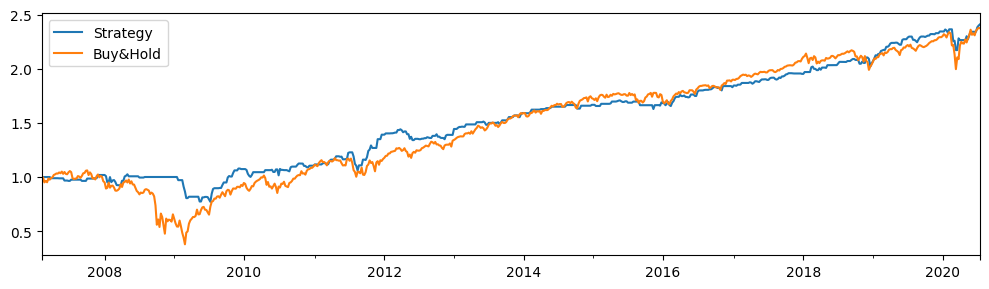



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0018739033254149206
Average Return Given A Signal: 0.00395664527444536
Volatility: 0.016474670315039103
Volatility Given A Signal: 0.023784939673205652
Sharpe Ratio: 0.8202233362907744
Sharpe Ratio Given A Signal: 1.1995731426559741


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.47360912981455067 % of the time
Flat: 0.5263908701854494 % of the time
Short: 0.0 % of the time




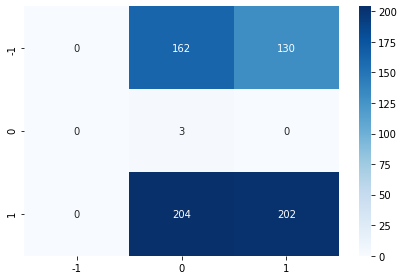

{'feature_name': 'US_2y_v_OIS_ZSc52', 'param_grid': {'func': [<ufunc 'less'>], 'thresh': array([-2.        , -1.89473684, -1.78947368, -1.68421053, -1.57894737,
       -1.47368421, -1.36842105, -1.26315789, -1.15789474, -1.05263158,
       -0.94736842, -0.84210526, -0.73684211, -0.63157895, -0.52631579,
       -0.42105263, -0.31578947, -0.21052632, -0.10526316,  0.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f73ecc913a0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac610>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', s

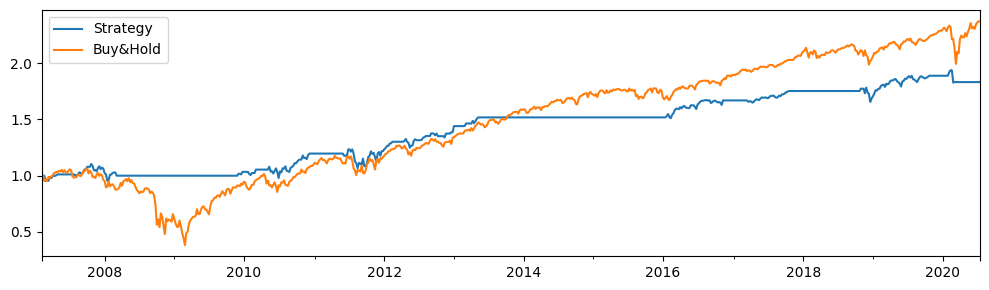



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0010810999414175332
Average Return Given A Signal: 0.0027862171284326865
Volatility: 0.014693720052419312
Volatility Given A Signal: 0.023514269940752567
Sharpe Ratio: 0.5305615267986862
Sharpe Ratio Given A Signal: 0.8544470014550298


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.3880171184022825 % of the time
Flat: 0.6119828815977175 % of the time
Short: 0.0 % of the time




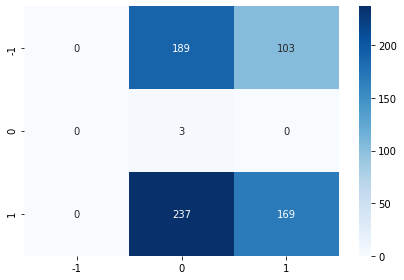

{'feature_name': 'US_Bond_30y_ZSc52', 'param_grid': {'func': [<ufunc 'less'>], 'thresh': array([-2.        , -1.89473684, -1.78947368, -1.68421053, -1.57894737,
       -1.47368421, -1.36842105, -1.26315789, -1.15789474, -1.05263158,
       -0.94736842, -0.84210526, -0.73684211, -0.63157895, -0.52631579,
       -0.42105263, -0.31578947, -0.21052632, -0.10526316,  0.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f73ecc913a0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac910>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', s

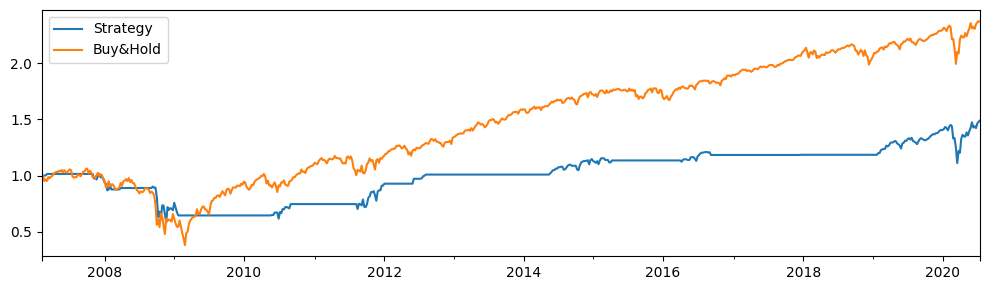



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0005073662342387937
Average Return Given A Signal: 0.0017783186510069722
Volatility: 0.019772903144116595
Volatility Given A Signal: 0.03705390324858709
Sharpe Ratio: 0.18503453535920042
Sharpe Ratio Given A Signal: 0.34608062947128676


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.2867332382310984 % of the time
Flat: 0.7132667617689016 % of the time
Short: 0.0 % of the time




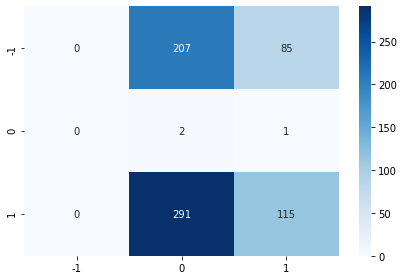

{'feature_name': 'US_10y_2y_ZSc52', 'param_grid': {'func': [<ufunc 'less'>], 'thresh': array([-2.        , -1.89473684, -1.78947368, -1.68421053, -1.57894737,
       -1.47368421, -1.36842105, -1.26315789, -1.15789474, -1.05263158,
       -0.94736842, -0.84210526, -0.73684211, -0.63157895, -0.52631579,
       -0.42105263, -0.31578947, -0.21052632, -0.10526316,  0.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f73ecc913a0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac4f0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', ste

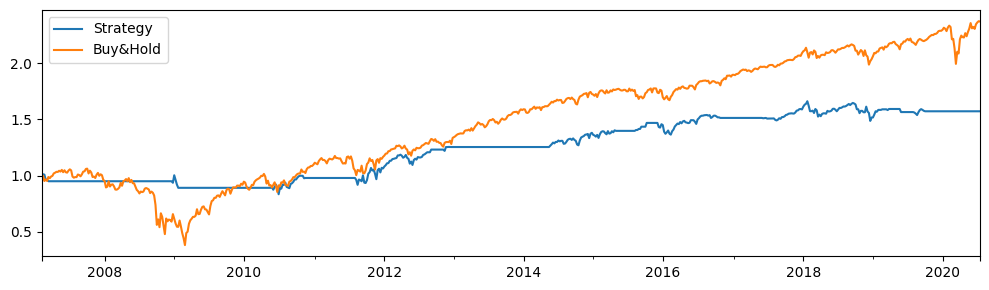



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0007213758517011184
Average Return Given A Signal: 0.00176812752462407
Volatility: 0.013860581802861415
Volatility Given A Signal: 0.021679619621233197
Sharpe Ratio: 0.3753028060702243
Sharpe Ratio Given A Signal: 0.5881168178197648


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.4108416547788873 % of the time
Flat: 0.5891583452211127 % of the time
Short: 0.0 % of the time




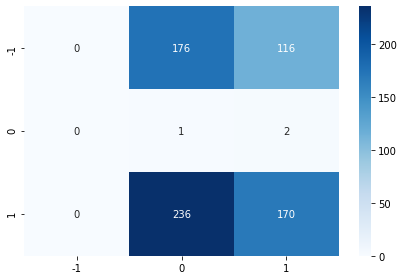

{'feature_name': 'GLOB_EM_HCSp_Chg', 'param_grid': {'func': [<ufunc 'greater'>], 'thresh': array([0.        , 0.31578947, 0.63157895, 0.94736842, 1.26315789,
       1.57894737, 1.89473684, 2.21052632, 2.52631579, 2.84210526,
       3.15789474, 3.47368421, 3.78947368, 4.10526316, 4.42105263,
       4.73684211, 5.05263158, 5.36842105, 5.68421053, 6.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f73ecc913a0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f747c2ac5e0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='Y5r3vZ267nWG9gfiKTYTWb')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='Y3xLbDVNVkuXZGpQwRiiwC', step=-1))]), 'targe

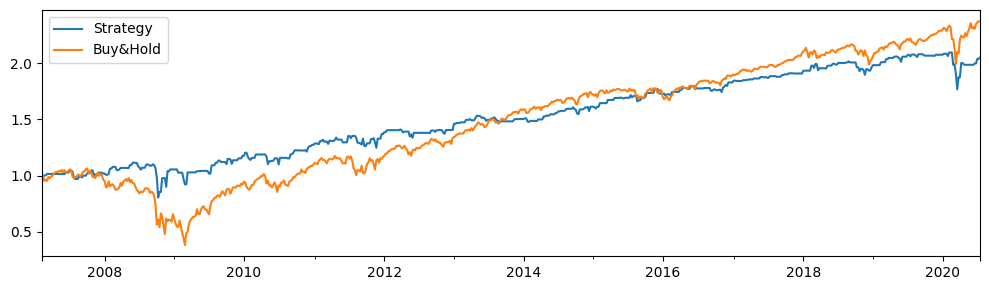



BUY&HOLD STRATEGY
Average Return: 0.0016088650857138825
Average Return Given A Signal: 0.0016157799786324235
Volatility: 0.02653006768650237
Volatility Given A Signal: 0.026586890797267906
Sharpe Ratio: 0.4373034875290913
Sharpe Ratio Given A Signal: 0.4382443669137855




NEW STRATEGY
Average Return: 0.0012700543131720745
Average Return Given A Signal: 0.002739409457026536
Volatility: 0.02152191065635934
Volatility Given A Signal: 0.03157035392749465
Sharpe Ratio: 0.425542696639067
Sharpe Ratio Given A Signal: 0.6257187540237349


BUY&HOLD STRATEGY
Long: 0.579172610556348 % of the time
Flat: 0.0042796005706134095 % of the time
Short: 0.4165477888730385 % of the time


NEW STRATEGY
Long: 0.4664764621968616 % of the time
Flat: 0.5335235378031383 % of the time
Short: 0.0 % of the time




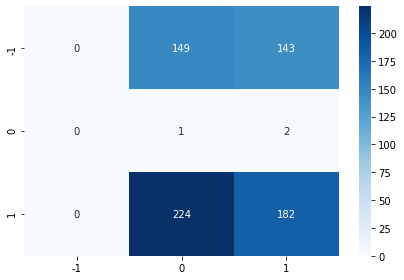

In [56]:
start_date = "2005"
SAVE = True  # This feature does NOT WORK yet. Can't pickle SubStrat unless we move into another file, but then Dask breaks...

if SAVE: 
    path = Path('logs', datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
    path.mkdir(parents=True)
    
for i, meta in enumerate(tqdm(substrat_meta_list)):
    
    print(meta)
    feature_name = meta['feature_name']
    target_name = meta['target_name']
    param_grid = meta['param_grid']
    splitter = meta['splitter']
    scoring_func = meta['scoring_func']
    feature_preprocessing = meta['feature_preprocessing']
    target_preprocessing = meta['target_preprocessing']

    features = FeatureFrame(df_master_weekly[[feature_name]].loc[start_date:].copy().dropna())

    target = FeatureFrame(df_master_weekly[[target_name]].loc[start_date:].copy().dropna()).squeeze()
    target = target_preprocessing.fit_transform(target)

    if feature_preprocessing is not None:
        estimator = deepcopy(feature_preprocessing)
        estimator.steps.append(('model', make_model(param_grid, scoring_func)))
    else:
        estimator = make_model(param_grid, scoring_func)

    wf = WindowFrame(
        features=features,
        target=target,
        splitter=splitter,
        estimator=estimator
    )

    wf.fit(parallel=True)
    
    # The magic line that solves all our pickling problems...
    SubStrat.__module__ = '__main__'
    
    if SAVE: 
        file_path = Path(path, f'window_frame_{i:03d}.h5')
        with open(file_path, "wb") as dill_file:
            dill.dump(meta, dill_file)
            dill.dump(wf, dill_file)
            
        meta_path = Path(path, f'window_frame_{i:03d}.json')
        with open(meta_path, 'w') as fp:
            json.dump({k: repr(v) for k, v in meta.items()}, fp, indent=4)
            
    # This next section is wrapped in a function so that we can load new 'wf'...
    # ... and process it without fitting again.
    def post_analysis(wf):
        signal = ThresholdSignSignal(wf, threshold=0)

        my_signals = signal.get_signals()
        optimal_signals = np.sign(wf.target.data).reindex(my_signals.index)

        strat_pnl = PNL(signal, asset_type=AssetType(level=False, log=True))

        buyhold_pnl = PNL(LongOnly(wf.target, my_signals.index), 
                          asset=wf.target.data,
                          asset_type=AssetType(level=False, log=True))

        fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=100)
        strat_pnl.get_pnl().plot(label='Strategy')
        buyhold_pnl.get_pnl().plot(label='Buy&Hold')
        ax.legend()
        plt.tight_layout()
        plt.show()

        

        def return_stats(rets, name=None):
            print('\n')
            
            if name: print(name)
            print(f'Average Return: {rets.mean()}')
            print(f'Average Return Given A Signal: {rets[rets.abs()>0].mean()}')

            print(f'Volatility: {rets.std()}')
            print(f'Volatility Given A Signal: {rets[rets.abs()>0].std()}')

            print(f'Sharpe Ratio: {np.sqrt(52)*rets.mean()/rets.std()}')
            print(f'Sharpe Ratio Given A Signal: {np.sqrt(52)*rets[rets.abs()>0].mean()/rets[rets.abs()>0].std()}')

            print('\n')

        return_stats(buyhold_pnl.get_returns(), 'BUY&HOLD STRATEGY')
        return_stats(strat_pnl.get_returns(), 'NEW STRATEGY')

        def signal_stats(signals, name=None):
            if name: print(name)
            print(f'Long: {(signals>0).mean()} % of the time')
            print(f'Flat: {(signals==0).mean()} % of the time')
            print(f'Short: {(signals<0).mean()} % of the time')
            print('\n')

        signal_stats(optimal_signals, 'BUY&HOLD STRATEGY')
        signal_stats(my_signals, 'NEW STRATEGY')

        labels = [-1, 0, 1]
        cm = sk.metrics.confusion_matrix(optimal_signals.astype(int).values, my_signals.astype(int).values, labels=labels)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
        ax.set(xlabel='Predicted', ylabel='True')
        plt.tight_layout()
        plt.show()
        
    post_analysis(wf)

In [57]:
!ls logs/

02_12_2020_15_38_56  02_12_2020_17_51_19  03_12_2020_16_55_43
02_12_2020_15_59_28  02_12_2020_17_52_03  03_12_2020_17_06_27
02_12_2020_16_09_23  02_12_2020_18_17_53  03_12_2020_17_06_54
02_12_2020_16_49_22  02_12_2020_18_38_04  03_12_2020_17_08_17
02_12_2020_17_15_30  02_12_2020_18_41_28  03_12_2020_17_08_48
02_12_2020_17_19_50  02_12_2020_18_43_07  03_12_2020_17_23_18
02_12_2020_17_26_34  02_12_2020_19_01_14  03_12_2020_17_26_17
02_12_2020_17_27_30  02_12_2020_19_08_54  03_12_2020_17_26_44
02_12_2020_17_28_30  03_12_2020_16_41_06  03_12_2020_17_29_21
02_12_2020_17_36_09  03_12_2020_16_43_00  03_12_2020_17_43_02


In [58]:
# folder_path = Path('logs')
# folder_path = folder_path.d
folder_path = Path('logs', '03_12_2020_17_43_02')

meta_list, wf_list = [], []
for file_path in tqdm(sorted(list(folder_path.glob('*.h5')))):
    with open(file_path, "rb") as dill_file:
        meta_list.append(dill.load(dill_file))
        wf_list.append(dill.load(dill_file))

In [59]:
results = []
names = [i['feature_name'] for i in substrat_meta_list]
df_thresh = pd.DataFrame(columns=names)

for wf, name in tqdm(list(zip(wf_list, names))):
    signal = ThresholdSignSignal(wf)
    results.append(signal.signals)
    
    is_pipeline = isinstance(wf[0].estimator, Pipeline)
    for w in wf:
        if is_pipeline:
            estimator = w.estimator[-1]
        else:
            estimator = w.estimator
        df_thresh.loc[w.training_end, name] = estimator.best_params_['thresh']
        
        

Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status
Monitor progress at http://10.27.2.239:33867/status



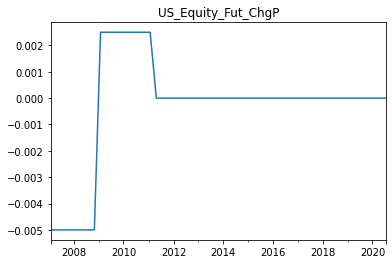

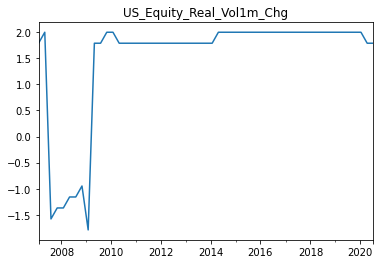

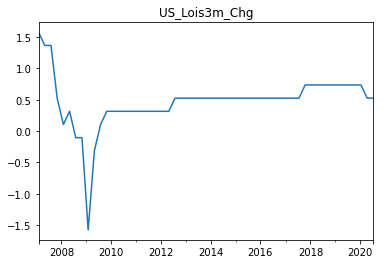

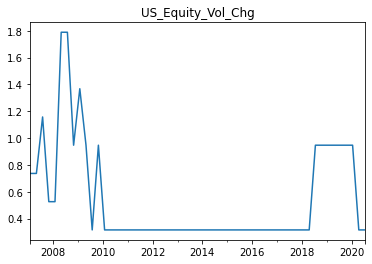

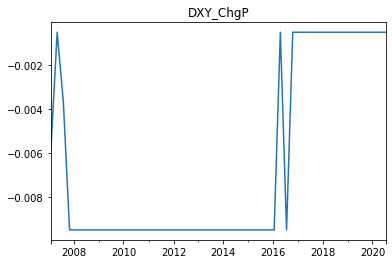

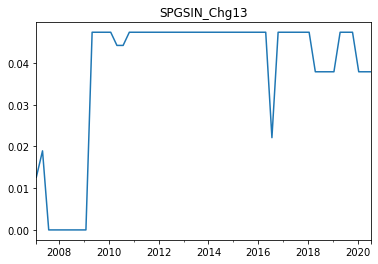

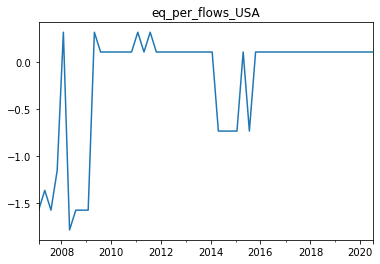

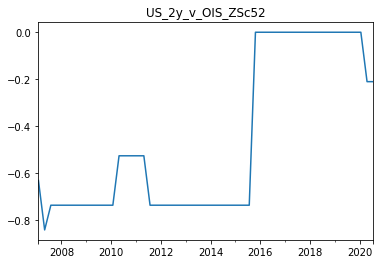

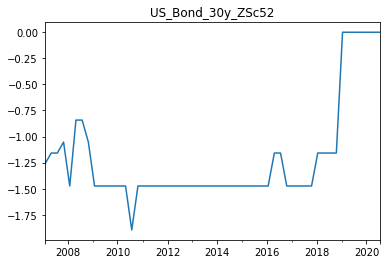

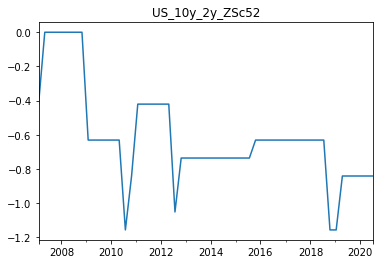

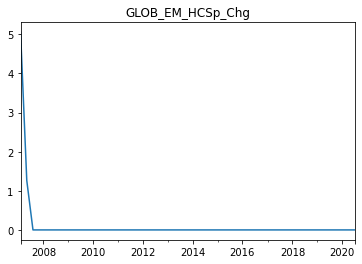

In [60]:
for i in df_thresh:
    df_thresh[i].plot(title=i)
    plt.show()

In [61]:
signals = pd.concat(results, axis=1)
signals.columns = [i['feature_name']+str(n) for n,i in enumerate(substrat_meta_list)]


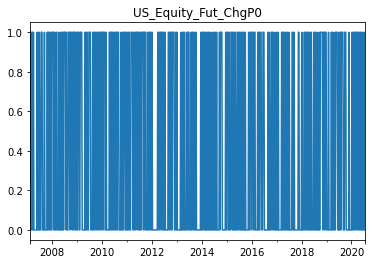

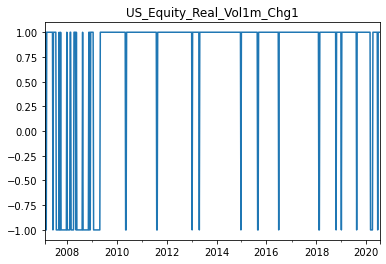

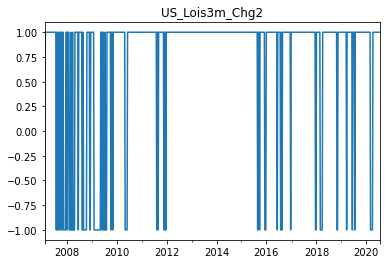

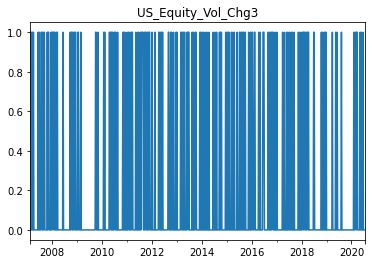

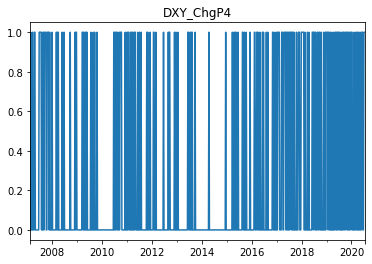

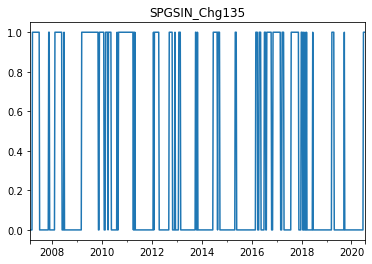

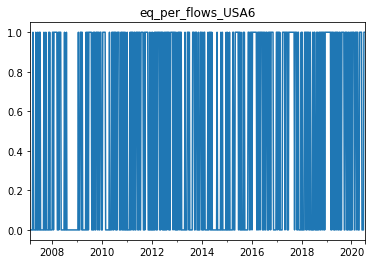

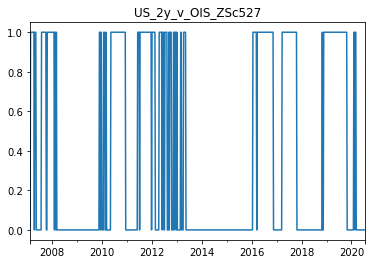

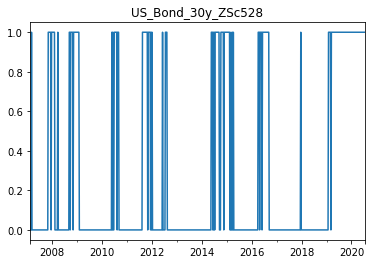

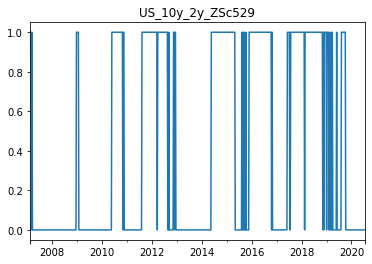

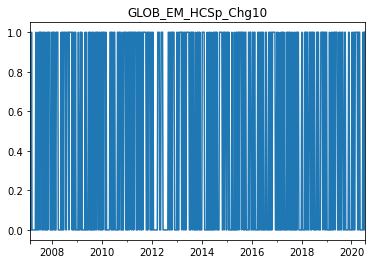

In [62]:
for i in signals.columns:
    signals[i].plot(title=i)
    plt.show()

In [63]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr

def plot_dendrogram(model, strats, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    R = dendrogram(linkage_matrix, labels=strats.columns, leaf_rotation=90, **kwargs)
    
    return R

def effective_weight_2by2(strats, plot=True):
    cl = AgglomerativeClustering(linkage='complete', affinity='precomputed', 
                             distance_threshold=0, n_clusters=None)
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    cl.fit(d_mat)
    
    if plot: 
        R = plot_dendrogram(cl, strats)
    
    def find_ancestor(model, target):
        for ind,pair in enumerate(model.children_):
            if target in pair:
                return [target]+find_ancestor(model, model.n_leaves_+ind)
        return [ind+model.n_leaves_]

    output = pd.Series(index=strats.columns, dtype='float64')
    for i, col in enumerate(strats):
        depth = len(find_ancestor(cl, i))-1
        output[col] = 0.5**depth
    return output

def effective_weight_even(strats, n_clusters=2):
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    
    cl = AgglomerativeClustering(linkage='complete', affinity='precomputed', n_clusters=n_clusters)
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    labels = cl.fit_predict(d_mat)
    unique_labels = np.unique(labels)
    
    output = pd.Series(data=np.ones(len(strats.columns)), index=strats.columns, dtype='float64')
    for label in unique_labels:
        idx = np.where(labels==label)[0]
        output.iloc[idx] = 1/(len(idx)*len(unique_labels))
    return output



Buy&Hold
Average Return: 0.0012711530780991679
Average Return Given A Signal: 0.0012766164867442933
Volatility: 0.026862264061830076
Volatility Given A Signal: 0.026919882009573185
Sharpe Ratio: 0.3412376255032753
Sharpe Ratio Given A Signal: 0.3419707560696119




Equally Weighted
Average Return: 0.0013070528056334323
Average Return Given A Signal: 0.0013434663002185282
Volatility: 0.011807337095397306
Volatility Given A Signal: 0.011968870713496177
Sharpe Ratio: 0.798257197600884
Sharpe Ratio Given A Signal: 0.8094225007934536




Equal Within Cluster
Average Return: 0.001381531418195898
Average Return Given A Signal: 0.0014138007651902547
Volatility: 0.010678117916553868
Volatility Given A Signal: 0.010800171254670293
Sharpe Ratio: 0.9329700993932014
Sharpe Ratio Given A Signal: 0.943972281917173




2by2 Weighted Clustering
Average Return: 0.001209154426442972
Average Return Given A Signal: 0.0012355936631727744
Volatility: 0.010576780020799427
Volatility Given A Signal: 0.010690

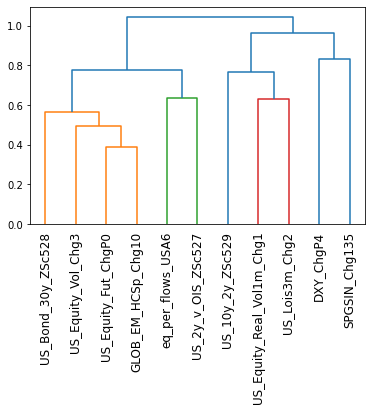

In [73]:
signals = pd.concat(results, axis=1)
strats = signals.multiply(df_master_weekly[asset].diff(), axis=0).astype(float)
strats.columns = [i['feature_name']+str(n) for n,i in enumerate(substrat_meta_list)]
strats = strats.dropna()

weight_2by2_cluster = effective_weight_2by2(strats, plot=True)
strats_2by2_cluster = weight_2by2_cluster * strats * len(weight_2by2_cluster)

N_CLUSTERS = 3  # SET THIS BY OBSERVING THE DENDROGRAM!
weight_even_cluster = effective_weight_even(strats, n_clusters=N_CLUSTERS)
strats_even_cluster = weight_even_cluster * strats * len(weight_even_cluster)

list_of_strats = [
    ('Buy&Hold', df_master_weekly[asset].diff().reindex(strats.index)),
    ('Equally Weighted', strats.mean(axis=1)),
    ('Equal Within Cluster', strats_even_cluster.mean(axis=1)),
    ('2by2 Weighted Clustering', strats_2by2_cluster.mean(axis=1)),
]

# NORMALISE BY VOL!!!
# for i in range(len(list_of_strats)):
#     list_of_strats[i] = (list_of_strats[i][0], list_of_strats[i][1]/list_of_strats[i][1].std())

def return_stats(rets, name=None):
    print('\n')

    if name: print(name)
    print(f'Average Return: {rets.mean()}')
    print(f'Average Return Given A Signal: {rets[rets.abs()>0].mean()}')

    print(f'Volatility: {rets.std()}')
    print(f'Volatility Given A Signal: {rets[rets.abs()>0].std()}')

    print(f'Sharpe Ratio: {np.sqrt(52)*rets.mean()/rets.std()}')
    print(f'Sharpe Ratio Given A Signal: {np.sqrt(52)*rets[rets.abs()>0].mean()/rets[rets.abs()>0].std()}')

    print('\n')

for name, rets in list_of_strats:
    return_stats(rets, name=name)

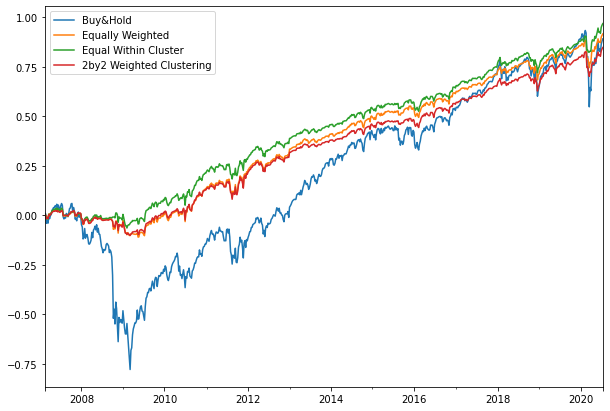

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for name, rets in list_of_strats:
    rets.cumsum().plot(ax=ax, label=name)
ax.legend()
plt.show()

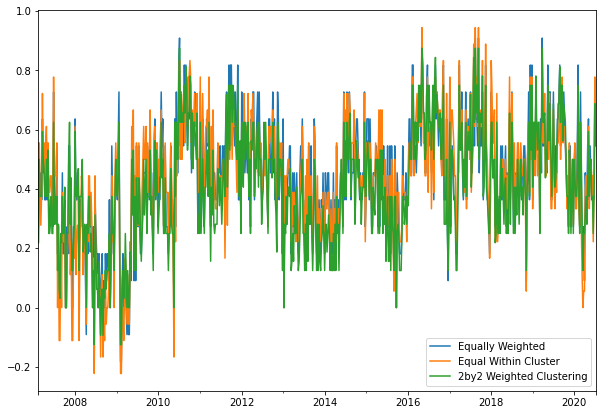

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
signals.mean(axis=1).plot(ax=ax, label='Equally Weighted')
(signals*weight_even_cluster.values*len(weight_even_cluster)).mean(axis=1).plot(ax=ax, label='Equal Within Cluster')
(signals*weight_2by2_cluster.values*len(weight_2by2_cluster)).mean(axis=1).plot(ax=ax, label='2by2 Weighted Clustering')
ax.legend()
plt.show()

In [76]:
pd.concat([weight_even_cluster,weight_2by2_cluster,pd.Series(1/strats.shape[1], index=strats.columns)], axis=1)

0        1         2
US_Equity_Fut_ChgP0        0.055556  0.03125  0.090909
US_Equity_Real_Vol1m_Chg1  0.111111  0.06250  0.090909
US_Lois3m_Chg2             0.111111  0.06250  0.090909
US_Equity_Vol_Chg3         0.055556  0.06250  0.090909
DXY_ChgP4                  0.166667  0.12500  0.090909
SPGSIN_Chg135              0.166667  0.12500  0.090909
eq_per_flows_USA6          0.055556  0.12500  0.090909
US_2y_v_OIS_ZSc527         0.055556  0.12500  0.090909
US_Bond_30y_ZSc528         0.055556  0.12500  0.090909
US_10y_2y_ZSc529           0.111111  0.12500  0.090909
GLOB_EM_HCSp_Chg10         0.055556  0.03125  0.090909

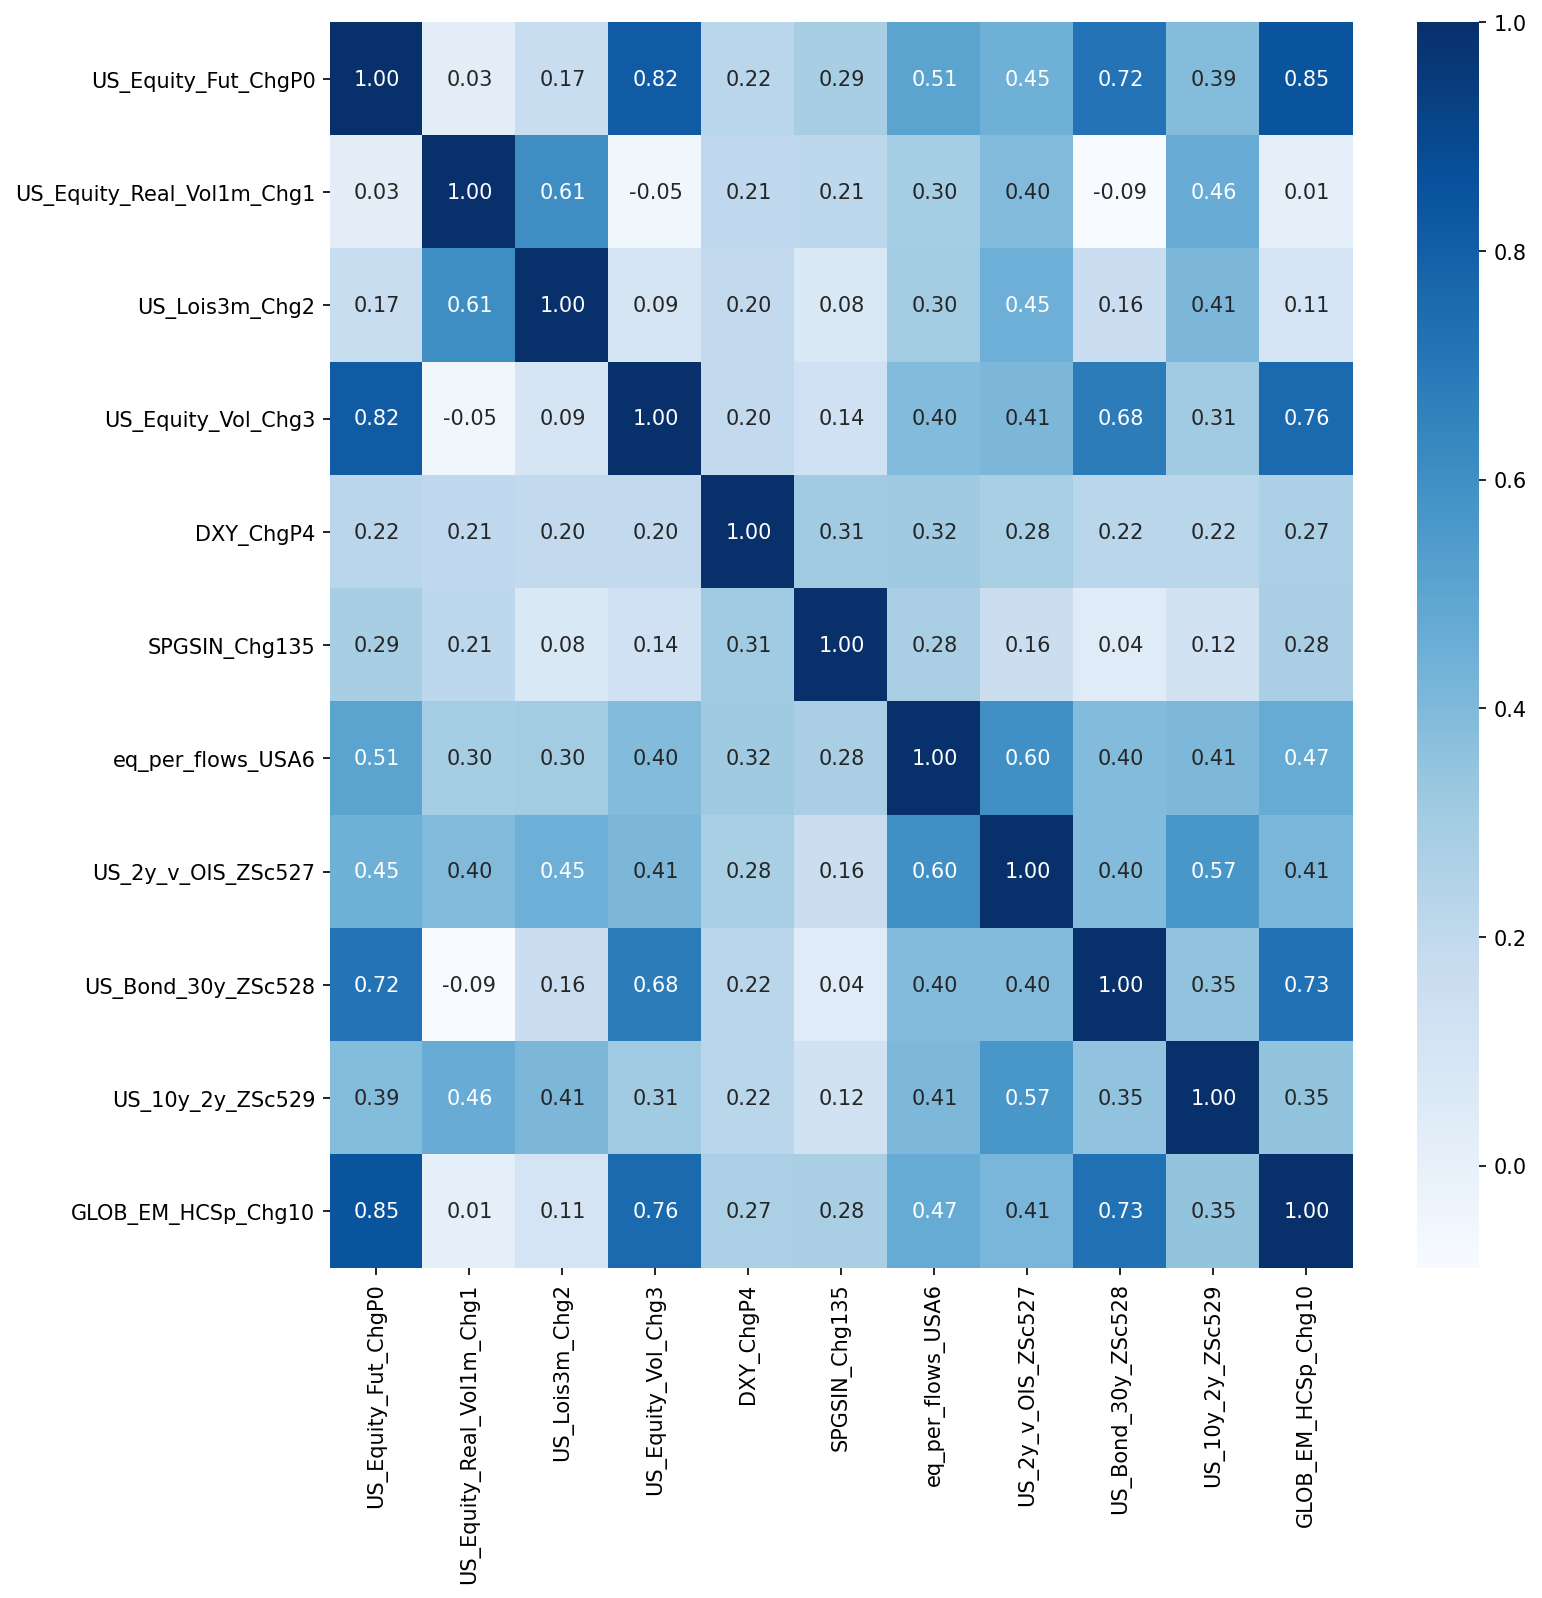

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11), dpi=150)
sns.heatmap(strats.dropna().astype(float).corr(), cmap='Blues', ax=ax, annot=True, fmt='.2f')
plt.show()

In [78]:
signals.columns = strats.columns

In [113]:
s = signals.iloc[:, 9]
test = df_master_weekly[[asset]].diff().join(df_master_weekly[[s.name[:-1]]].shift(1)).join(s)
for_corr = test[test[s.name]==1].iloc[:,:2]
for_corr.corr()

US_Equity_Fut  US_10y_2y_ZSc52
US_Equity_Fut         1.000000        -0.206582
US_10y_2y_ZSc52      -0.206582         1.000000

In [96]:
s

2007-02-16    1
2007-02-23    0
2007-03-02    0
2007-03-09    1
2007-03-16    0
             ..
2020-06-19    1
2020-06-26    0
2020-07-03    1
2020-07-10    0
2020-07-17    0
Name: US_Equity_Fut_ChgP0, Length: 701, dtype: object

In [85]:
df_master_weekly

UK_Equity_Vol  SEK_Equity_Vol  JPN_Nikkei_PE  US_Credit_IG_OAS  \
2000-01-07            NaN             NaN            NaN               NaN   
2000-01-14            NaN             NaN            NaN               NaN   
2000-01-21            NaN             NaN            NaN               NaN   
2000-01-28            NaN             NaN            NaN               NaN   
2000-02-04            NaN             NaN            NaN          0.606592   
...                   ...             ...            ...               ...   
2020-06-26          26.89           27.14        27.4870          0.693702   
2020-07-03          23.02           24.31        27.2690          0.658068   
2020-07-10          23.60           23.92        27.2499          0.641216   
2020-07-17          21.56           22.09        27.7457          0.633169   
2020-07-24          21.74           22.02        27.8132          0.622158   

            US_Credit_HY_OAS  JPN_Credit_IG_OAS  EMU_Credit_IG_OAS  \
2000-01-07               NaN                NaN                NaN   
2000-01-14               NaN                NaN                NaN   
2000-01-21               NaN                NaN                NaN   
2000-01-28               NaN                NaN                NaN   
2000-02-04          4.820000                NaN                NaN   
...                      ...                ...                ...   
2020-06-26          6.153414           0.624857           0.754222   
2020-07-03          6.003799           0.623595           0.728486   
2020-07-10          5.967674           0.604368           0.726914   
2020-07-17          5.563074           0.608347           0.689635   
2020-07-24          5.042923           0.619334           0.640341   

            EMU_Credit_HY_OAS  UK_Credit_IG_OAS  UK_Credit_HY_OAS  ...  \
2000-01-07                NaN          1.270000          5.790000  ...   
2000-01-14                NaN          1.220000          5.830000  ...   
2000-01-21                NaN          1.230000          5.600000  ...   
2000-01-28                NaN          1.220000          5.430000  ...   
2000-02-04                NaN          1.230000          5.510000  ...   
...                       ...               ...               ...  ...   
2020-06-26           5.316320          1.761242          6.900926  ...   
2020-07-03           5.225561          1.719609          6.835161  ...   
2020-07-10           5.249594          1.685940          6.926201  ...   
2020-07-17           5.072157          1.646381          6.825860  ...   
2020-07-24           4.816503          1.588846          6.715479  ...   

            US_Bond_30y_ZSc52  US_10y_2y_ZSc52  GLOB_EM_HCSp_Chg  \
2000-01-07                NaN              NaN               NaN   
2000-01-14                NaN              NaN               NaN   
2000-01-21                NaN              NaN               NaN   
2000-01-28                NaN              NaN               NaN   
2000-02-04                NaN              NaN               NaN   
...                       ...              ...               ...   
2020-06-26          -1.279918         1.258270              7.01   
2020-07-03          -1.109963         1.441882            -12.02   
2020-07-10          -1.274785         1.250134              4.45   
2020-07-17          -1.247791         1.148087             -7.32   
2020-07-24          -1.429637         0.887931            -10.02   

            US_HYIG_Spread  US_Credit_HY_OAS_Chg  US_Credit_HY_IG_Chg  \
2000-01-07             NaN                   NaN                  NaN   
2000-01-14             NaN                   NaN                  NaN   
2000-01-21             NaN                   NaN                  NaN   
2000-01-28             NaN                   NaN                  NaN   
2000-02-04        4.213408                   NaN                  NaN   
...                    ...                   ...                  ...   
2020-06-26       